![A soccer pitch for an international match.](soccer-pitch.jpg)

You're working as a sports journalist at a major online sports media company, specializing in soccer analysis and reporting. You've been watching both men's and women's international soccer matches for a number of years, and your gut instinct tells you that more goals are scored in women's international football matches than men's. This would make an interesting investigative article that your subscribers are bound to love, but you'll need to perform a valid statistical hypothesis test to be sure!

While scoping this project, you acknowledge that the sport has changed a lot over the years, and performances likely vary a lot depending on the tournament, so you decide to limit the data used in the analysis to only official `FIFA World Cup` matches (not including qualifiers) since `2002-01-01`.

You create two datasets containing the results of every official men's and women's international football match since the 19th century, which you scraped from a reliable online source. This data is stored in two CSV files: `women_results.csv` and `men_results.csv`.

The question you are trying to determine the answer to is:

> Are more goals scored in women's international soccer matches than men's?

You assume a **10% significance level**, and use the following null and alternative hypotheses:

$H_0$ : The mean number of goals scored in women's international soccer matches is the same as men's.

$H_A$ : The mean number of goals scored in women's international soccer matches is greater than men's.

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

# importing the men and women data 
men_data = pd.read_csv('men_results.csv')
women_data = pd.read_csv('women_results.csv')

# checking the data types and general format
print(women_data.head())
print(women_data.dtypes)

# cleaning datasets
def cleaning_func(data, gender):
    """ receive the data and choose the 'FIFA World Cup' after 
        2002-01-01. Also, add a column where the gender is defined.
        Args: 
            data (DataFrame): the data to be cleaned.
        Returns: 
            DataFrame : the cleanded data. 
    """
    cleaned_data = data.loc[data['tournament']=='FIFA World Cup']
    cleaned_data['date'] = pd.to_datetime(cleaned_data['date'], infer_datetime_format = True)
    cleaned_data = cleaned_data[cleaned_data['date'] >= '2002-01-01']
    cleaned_data['total_score'] = cleaned_data['home_score'] + cleaned_data['away_score']
    cleaned_data['gender'] = gender
    return cleaned_data

women_data_cleaned  = cleaning_func(women_data, 'w')
men_data_cleaned = cleaning_func(men_data, 'm')
merged_data = pd.concat([women_data_cleaned, men_data_cleaned])
print(merged_data.head())


   Unnamed: 0        date home_team  ... home_score  away_score        tournament
0           0  1969-11-01     Italy  ...          1           0              Euro
1           1  1969-11-01   Denmark  ...          4           3              Euro
2           2  1969-11-02   England  ...          2           0              Euro
3           3  1969-11-02     Italy  ...          3           1              Euro
4           4  1975-08-25  Thailand  ...          3           2  AFC Championship

[5 rows x 7 columns]
Unnamed: 0     int64
date          object
home_team     object
away_team     object
home_score     int64
away_score     int64
tournament    object
dtype: object
      Unnamed: 0       date      home_team  ...      tournament  total_score  gender
1600        1600 2003-09-20        Nigeria  ...  FIFA World Cup            3       w
1601        1601 2003-09-20         Norway  ...  FIFA World Cup            2       w
1602        1602 2003-09-20        Germany  ...  FIFA World Cup       

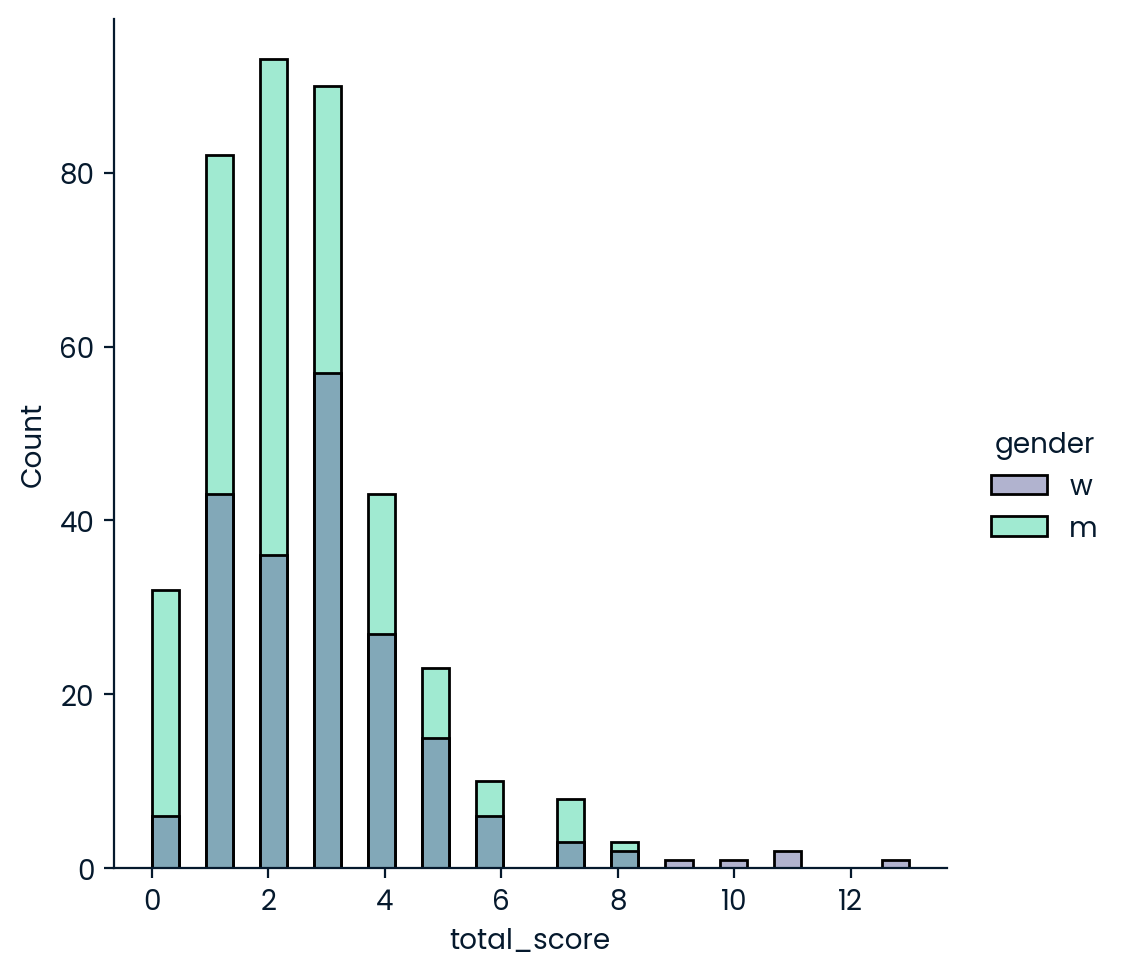

              mean         var
       total_score total_score
gender                        
m         2.513021    2.730901
w         2.980000    4.090050


In [16]:
# visualizing the data
sns.displot(data = merged_data,
            x = 'total_score',
            hue = 'gender')
plt.show()

# The figure shows that the data has a poisson or neg-binomial] distribution
# Therefore, one can chech  whether a neg-binomial test is required
table_binomial = merged_data.pivot_table(index = 'gender',
                                        values = 'total_score',
                                        aggfunc = [np.mean,np.var])
print(table_binomial)

In [17]:
# conducting a Poisson test
from statsmodels.formula.api import poisson

poisson_model = poisson("total_score ~ gender", data = merged_data).fit()

poisson_model.summary()

Optimization terminated successfully.
         Current function value: 1.910452
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:            total_score   No. Observations:                  584
Model:                        Poisson   Df Residuals:                      582
Method:                           MLE   Df Model:                            1
Date:                Thu, 10 Jul 2025   Pseudo R-squ.:                0.004705
Time:                        16:31:34   Log-Likelihood:                -1115.7
converged:                       True   LL-Null:                       -1121.0
Covariance Type:            nonrobust   LLR p-value:                  0.001163
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.9215      0.032     28.625      0.000       0.858       0.985
gender[T.w]     0.1704      0.052      3.272      0.001       0.068       0.273
===============================================================================
"""

In [20]:
# conducting a non-parametric test
from scipy.stats import mannwhitneyu

mwu_stat, p_val = mannwhitneyu(women_data_cleaned['total_score'], 
                               men_data_cleaned['total_score'],
                              alternative = 'greater')

result = "reject" if p_val <= 0.10 else "fail to reject"

print(f"mwu_stat: {mwu_stat:.3f}, p_val: {p_val:.3f}, and result: {result}")


result_dict = {"p_val": p_val, "result": result}


mwu_stat: 43273.000, p_val: 0.005, and result: reject
